In [1]:
%load_ext autoreload
%autoreload 2

# FastAI exploration

This kernel will make a small patch to fastai to enable it to read dicom files, and will then use the standard guidelines from the fastai course to explore this dataset.

In [2]:
# Patch dataset.py until my pull request https://github.com/fastai/fastai/pull/777
# has been incorporated.
import fastai
import fastai.dataset
import pydicom

def isdicom(fn):
    '''True if the fn points to a DICOM image'''
    if fn.endswith('.dcm'):
        return True
    # Dicom signature from the dicom spec.
    with open(fn) as fh:
        fh.seek(0x80)
        return fh.read(4)=='DICM'


def open_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn) and not str(fn).startswith("http"):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn) and not str(fn).startswith("http"):
        raise OSError('Is a directory: {}'.format(fn))
    elif isdicom(fn):
        slice = pydicom.read_file(fn)
        if slice.PhotometricInterpretation.startswith('MONOCHROME'):
            # Make a fake RGB image
            im = np.stack([slice.pixel_array]*3,-1)
            return im / ((1 << slice.BitsStored)-1)
        else:
            # No support for RGB yet, as it involves various color spaces.
            # It shouldn't be too difficult to add though, if needed.
            raise OSError('Unsupported DICOM image with PhotometricInterpretation=={}'.format(slice.PhotometricInterpretation))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            if str(fn).startswith("http"):
                req = urllib.urlopen(str(fn))
                image = np.asarray(bytearray(req.read()), dtype="uint8")
                im = cv2.imdecode(image, flags).astype(np.float32)/255
            else:
                im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

fastai.dataset.isdicom=isdicom
fastai.dataset.pydicom=pydicom
fastai.dataset.open_image=open_image


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Setup

With the dicom reader in place, the normal flow of fitting from fastai should work. We choose a modest file size, and just do a few epochs of fitting.

In [3]:
from fastai.conv_learner import *

In [4]:
# Rewrite the train csv file to contain only two columns as expected by fastai
label_csv = '../input/rsna-pneumonia-detection-challenge/stage_1_train_labels.csv'
df = pd.read_csv(label_csv)
df[['patientId','Target']].to_csv('train_target_labels.csv',index=False)
label_csv = 'train_target_labels.csv'
df = pd.read_csv(label_csv)
df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [6]:
PATH = '../input/rsna-pneumonia-detection-challenge'
TMP_PATH = "/tmp/tmp"
MODEL_PATH = "/tmp/model/"
sz = 224
arch = resnet34
bs = 64

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 43704511.28it/s]
/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [8]:
n = len(df)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [18]:
aug_tfms=transforms_side_on # Use None for faster testing
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.2)
data = ImageClassifierData.from_csv(PATH, 'stage_1_train_images', label_csv, test_name='stage_1_test_images', 
                                    val_idxs=val_idxs, 
                                    suffix='.dcm', 
                                    tfms=tfms,  # just for fast testing
                                    bs=bs)

In [19]:
learn = ConvLearner.pretrained(arch, data, tmp_name=TMP_PATH, models_name=MODEL_PATH)

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [20]:
ImageClassifierData.from_csv??

In [12]:
learn.lr_find()

 82%|████████▏ | 299/363 [08:08<01:09,  1.08s/it, loss=2.44] 

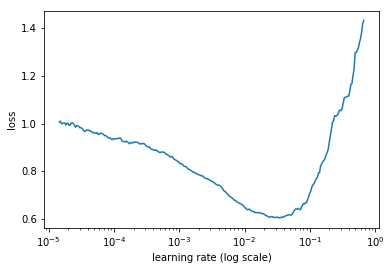

In [13]:
learn.sched.plot()

In [21]:
lr = 2e-2

# Fitting
Just run a few epochs of fitting

In [ ]:
learn.fit(lr, 1, cycle_len = 3, cycle_mult = 1)

  0%|          | 0/363 [00:00<?, ?it/s]

In [ ]:
learn.save('')

In [ ]:
learn.fit(0.02,3)

# Conclusion
With this setup in place, it should be straight-forward to apply further advanced concepts from the course, e.g. heatmaps.